# USe CUDA Kernel

In [1]:
import numpy as np
import cupy as cp
import cv2
import string
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import  animation

In [2]:
DIM = 512
n = 100
img = cp.zeros( (DIM, DIM, n), dtype=cp.uint8)

In [3]:
source = string.Template(
"""
extern "C"{
const int DIM=${DIM};
struct cuComplex{
    float r;
    float i;
    
    __device__ cuComplex( float a, float b): r(a), i(b) {}
    
    __device__ float magnitude2(){
        return r * r + i * i;
    }
    
    __device__ cuComplex operator*(const cuComplex &a){
        return cuComplex( r * a.r - i * a.i,  i * a.r + r * a.i);
    }
    
    __device__ cuComplex operator+(const cuComplex &a){
        return cuComplex(r + a.r, i + a.i);
    }    
};

__device__ int julia(int x, int y, int n){
    const float scale = 1.5;
    float jx = scale * (float)(DIM/2 - x)/(DIM/2);
    float jy = scale * (float)(DIM/2 - y)/(DIM/2);
    cuComplex c(-0.8, 0.156);
    cuComplex a(jx, jy);
    
    for(int i =0; i < n; i++){
        a = a * a + c;
        if (a.magnitude2() > 1000){
            return 0;
        }
    }
    return 1;
};

__global__ void kernel(CArray<${dtype}, 2> dst, int n){    
    int idx[] = { blockIdx.x,  blockIdx.y};
    dst[idx] = 255 * julia(blockIdx.x, blockIdx.y, n);
}
}
""").substitute(DIM=DIM, dtype=cp.core.core._get_typename(cp.uint8))

kernel = cp.core.core.compile_with_cache(source).get_function("kernel")

In [4]:
for i in range(n):
    kernel(grid=(DIM, DIM), block=(1,), args=(img[..., i], i))

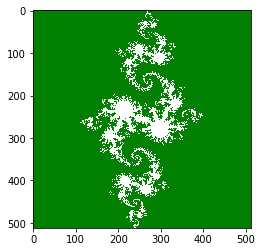

In [5]:
img_ = img.get()
fig =plt.figure()
ims = []
for i in range(n):
    ims.append( [plt.imshow(img_[..., i], animated=True, cmap="ocean") ])

In [11]:
ani = animation.ArtistAnimation(fig, ims, interval=5, blit=True,
                                repeat_delay=0)
ani.save("../../temp/julia.gif",  writer='imagemagick', fps=30)

![](../../../files/temp/julia.gif)